In [2]:
# !pip install catboost

In [4]:
# !pip install vaex

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import vaex

from sklearn.dummy import DummyRegressor
from sklearn.isotonic import IsotonicRegression

from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score, cross_val_predict

from catboost import CatBoostRegressor

from scipy.stats import zscore

# settings
sns.set()
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
%config InlineBackend.figure_format = 'svg'
np.random.seed(111)

In [2]:
# Data
# https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/data?select=train.csv

# Columns to load
dtypes = {
    'fare_amount':'float32',
    'pickup_datetime':'str',
    'pickup_longitude':'float32',
    'pickup_latitude':'float32',
    'dropoff_longitude':'float32',
    'dropoff_latitude':'float32'
}

# Load data
train = pd.read_csv('train.csv.zip',
                                       usecols=dtypes.keys(), # 読み込むカラムを絞っておく。
                                       dtype=dtypes)

# Convert pickup time column to datetime
train['pickup_datetime'] = train['pickup_datetime'].str.slice(0, 16)
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'] ,
                                                                             utc=True,
                                                                             format='%Y-%m-%d %H:%M')

In [3]:
train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,4.5,2009-06-15 17:26:00+00:00,-73.844315,40.721317,-73.841614,40.712276
1,16.9,2010-01-05 16:52:00+00:00,-74.016045,40.711304,-73.979271,40.782005
2,5.7,2011-08-18 00:35:00+00:00,-73.982735,40.761269,-73.991241,40.750561
3,7.7,2012-04-21 04:30:00+00:00,-73.987129,40.733143,-73.991570,40.758091
4,5.3,2010-03-09 07:51:00+00:00,-73.968094,40.768009,-73.956657,40.783764


In [13]:
train.memory_usage()

Index                      128
fare_amount          221695424
pickup_datetime      443390848
pickup_longitude     221695424
pickup_latitude      221695424
dropoff_longitude    221695424
dropoff_latitude     221695424
dtype: int64

In [16]:
print('Column\tPercent Null')
for col in train:
    print(col, 100*train[col].isnull().sum()/train.shape[0])

Column	Percent Null
fare_amount 0.0
pickup_datetime 0.0
pickup_longitude 0.0
pickup_latitude 0.0
dropoff_longitude 0.0006784082291206876
dropoff_latitude 0.0006784082291206876


In [4]:
train.dropna(inplace=True)

In [5]:
# Extract useful time information
train['min_of_daay'] = (60*train['pickup_datetime'].dt.hour + train['pickup_datetime'].dt.minute).astype('int32')
train['day_of_week'] = (train['pickup_datetime'].dt.dayofweek.astype('int32'))
train['day_of_year'] = (train['pickup_datetime'].dt.dayofyear.astype('int32'))
train['year'] = train['pickup_datetime'].dt.year.astype('int32')

# Remove original datetime column
train.drop('pickup_datetime', axis=1, inplace=True)

INFO:MainThread:numexpr.utils:NumExpr defaulting to 8 threads.


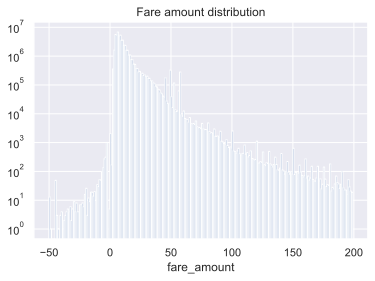

In [20]:
# Plot distribution of fares
plt.hist(train['fare_amount'],
                bins=np.arange(-50, 200),
                log=True)
plt.xlabel('fare_amount')
plt.title('Fare amount distribution');

In [6]:
# Function to remove rows outside range
def clip(df, a, b, col):
    for c in col:
        df = df[(df[c] > a) & (df[c] < b) ]
    return df

# Remove rows with outlier fare values
train = clip(train, 1, 200, ['fare_amount'])

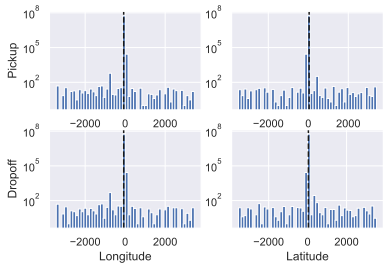

In [26]:
# Plot distribution of pickup longitudes
fig, ax = plt.subplots(2, 2)
nyc_lon = -74
nyc_lat = 40.7

ax[0, 0].axvline(nyc_lon, linestyle='--', color='k')
ax[0, 0].hist(train['pickup_longitude'], bins=50, log=True)
ax[0, 0].set_ylabel('Pickup')

ax[1, 0].axvline(nyc_lon, linestyle='--', color='k')
ax[1, 0].hist(train['dropoff_longitude'], bins=50, log=True)
ax[1, 0].set_xlabel('Longitude')
ax[1, 0].set_ylabel('Dropoff')

ax[0, 1].axvline(nyc_lat, linestyle='--', color='k')
ax[0, 1].hist(train['pickup_latitude'], bins=50, log=True)

ax[1, 1].axvline(nyc_lat, linestyle='--', color='k')
ax[1, 1].hist(train['dropoff_latitude'], bins=50, log=True)
ax[1, 1].set_xlabel('Latitude');

In [7]:
# Remove geographical outliers
train = clip(train, -75, -72.5,
                    ['pickup_longitude', 'dropoff_longitude'])
train = clip(train, 40, 41.5,
                    ['pickup_latitude', 'dropoff_latitude'])

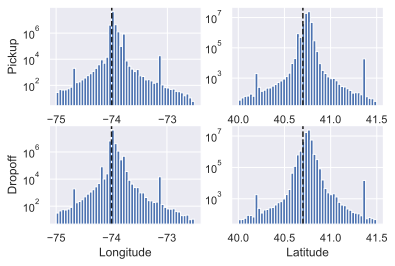

In [41]:
# Plot distribution of pickup longitudes
fig, ax = plt.subplots(2, 2)
nyc_lon = -74
nyc_lat = 40.7

ax[0, 0].axvline(nyc_lon, linestyle='--', color='k')
ax[0, 0].hist(train['pickup_longitude'], bins=50, log=True)
ax[0, 0].set_ylabel('Pickup')

ax[1, 0].axvline(nyc_lon, linestyle='--', color='k')
ax[1, 0].hist(train['dropoff_longitude'], bins=50, log=True)
ax[1, 0].set_xlabel('Longitude')
ax[1, 0].set_ylabel('Dropoff')

ax[0, 1].axvline(nyc_lat, linestyle='--', color='k')
ax[0, 1].hist(train['pickup_latitude'], bins=50, log=True)

ax[1, 1].axvline(nyc_lat, linestyle='--', color='k')
ax[1, 1].hist(train['dropoff_latitude'], bins=50, log=True)
ax[1, 1].set_xlabel('Latitude');

In [8]:
# Create vaex df from pandas df
vdf = vaex.from_pandas(train)

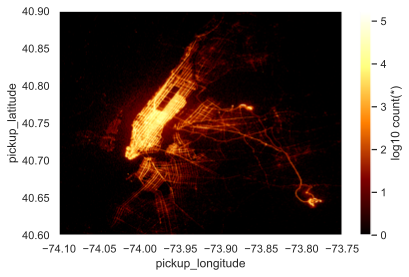

In [44]:
# Plot pickup locations as a heatmap
lims = [[-74.1, -73.75], [40.6, 40.9]]
cmap = matplotlib.cm.afmhot
cmap.set_bad('black', 1.)
vdf.plot('pickup_longitude', 'pickup_latitude',
                limits=lims, colormap=cmap,
                f='log10', shape=500,
                interpolation='spline16')

# Turn off grid
plt.gca().grid(False)

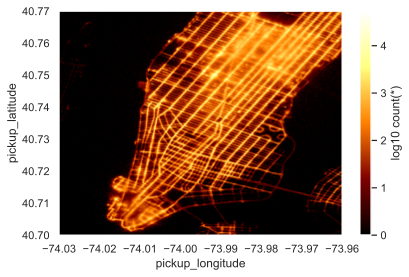

In [46]:
# Plot pickup locations as a heatmap
lims = [[-74.03, -73.96],[40.70, 40.77]]

vdf.plot('pickup_longitude', 'pickup_latitude',
                limits=lims, colormap=cmap,
                f='log10', shape=500,
                interpolation='spline16')

# Turn off grid
plt.gca().grid(False)

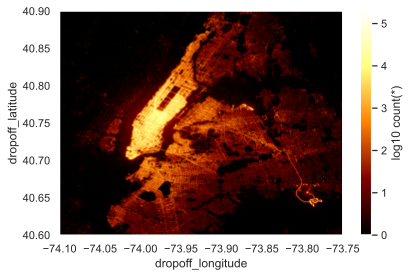

In [47]:
# Plot dropoff locations as a heatmap
lims = [[-74.1, -73.75], [40.6, 40.9]]

vdf.plot('dropoff_longitude', 'dropoff_latitude',
                limits=lims, colormap=cmap,
                f='log10', shape=500,
                interpolation='spline16')

# Turn off grid
plt.gca().grid(False)

In [52]:
# Create a divergent colormap
c_data = [
                    [0.8, 0.8, 1.0],
                    [0.3, 0.4, 0.8],
                    [0.1, 0.2, 0.5],
                    [0.0, 0.2, 0.0],
                    [0.5, 0.2, 0.1],
                    [0.8, 0.4, 0.3],
                    [1.0, 0.8, 0.8]
]

BluRdDiv = (matplotlib.colors.LinearSegmentedColormap.from_list('BluRdDiv',c_data))
plt.register_cmap(cmap=BluRdDiv)

# Function to plot difference in pickups/dropoffs
def PlotDiff(df, lims, shape=500, cmap='BluRdDiv'):
    p_count = df.count(binby=[df.pickup_longitude,
                                                     df.pickup_latitude],
                                        limits=lims,
                                        shape=shape)
    d_count = df.count(binby=[df.dropoff_longitude,
                                                     df.dropoff_latitude],
                                        limits=lims,
                                        shape=shape)
    log_diffs = (np.log(np.abs(d_count - p_count))* np.sign(d_count - p_count))
    t_cmap = plt.get_cmap(cmap)
    t_cmap.set_bad('black', 1.)
    
    vlim = np.nanmax(np.abs(log_diffs))
    plt.imshow(log_diffs.T, origin='lower',
                          cmap=t_cmap,
                          vmin=-vlim,
                          vmax=vlim,
                          extent=[lims[0][0], lims[0][1],
                                         lims[1][0], lims[1][1]])
    ax = plt.gca()
    ax.grid(False)
    cbar = plt.colorbar()
    cbar.set_label('log(dropoffs-pickups)', rotation=270)

/Users/Sakaue_2/perry_project/venv/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log
/Users/Sakaue_2/perry_project/venv/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in multiply


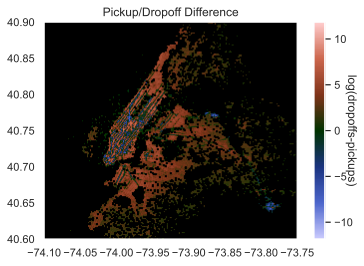

In [54]:
# Plot difference in pickup/dropoff locations
lims = [[-74.1, -73.75], [40.6, 40.9]]

PlotDiff(vdf, lims)
plt.title('Pickup/Dropoff Difference');

/Users/Sakaue_2/perry_project/venv/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log
/Users/Sakaue_2/perry_project/venv/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in multiply


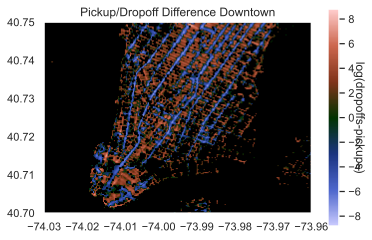

In [55]:
# Plot difference downtown
lims = [[-74.03, -73.96], [40.70, 40.75]]

PlotDiff(vdf, lims)
plt.title('Pickup/Dropoff Difference Downtown');

/Users/Sakaue_2/perry_project/venv/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log
/Users/Sakaue_2/perry_project/venv/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in multiply


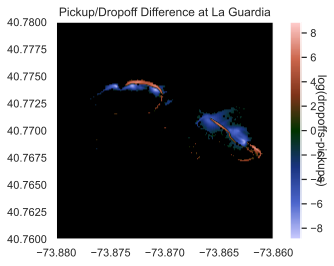

In [57]:
# Plot difference around La Guardia
lims = [[-73.88, -73.86],[40.76, 40.78]]
PlotDiff(vdf, lims)
plt.title('Pickup/Dropoff Difference at La Guardia');

/Users/Sakaue_2/perry_project/venv/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log
/Users/Sakaue_2/perry_project/venv/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in multiply


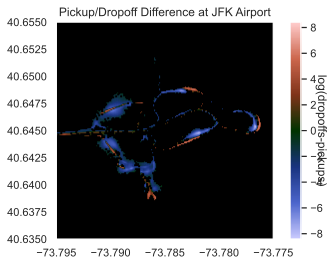

In [58]:
# Plot difference around JFK
lims = [[-73.795, -73.775],[40.635, 40.655]]
PlotDiff(vdf, lims)
plt.title('Pickup/Dropoff Difference at JFK Airport');

## Model

In [10]:
# Separate in- from dependent variables
x_taxi = train.drop('fare_amount', axis=1)
y_taxi = train['fare_amount']

# Take only 1st million rows
take_n = 1000000
x_taxi = x_taxi[:take_n]
y_taxi = y_taxi[:take_n]

# Make Mean Absolute Error scorer
mae_scorer = make_scorer(mean_absolute_error)

# Function to print cross-validated mean abs deviation
def cv_mae(regressor, x, y, cv=3, scorer=mae_scorer):
    scores = cross_val_score(regressor,
                                                    x, y, cv=cv,
                                                    scoring=scorer)
    print('MAE:', scores.mean())

In [11]:
# MAE from predictiing just the mean
cv_mae(DummyRegressor(), x_taxi, y_taxi)

MAE: 5.991544246673584


In [12]:
# Distance between pickup and dropoff locations
dist = np.sqrt(
                        np.power(x_taxi['pickup_longitude'] - x_taxi['dropoff_longitude'], 2) + 
                        np.power(x_taxi['pickup_latitude'] - x_taxi['dropoff_latitude'], 2))

# MAE from using just distance as predictor
cv_mae(IsotonicRegression(out_of_bounds='clip'), dist, y_taxi)

MAE: 2.346418301264445


In [63]:
# Cross-validated MAE w/ CatBoost
cv_mae(CatBoostRegressor(), x_taxi, y_taxi)

0:	learn: 9.4112107	total: 110ms	remaining: 1m 49s
1:	learn: 9.2417461	total: 140ms	remaining: 1m 9s
2:	learn: 9.0796244	total: 168ms	remaining: 55.8s
3:	learn: 8.9254214	total: 198ms	remaining: 49.3s
4:	learn: 8.7768632	total: 230ms	remaining: 45.7s
5:	learn: 8.6343133	total: 259ms	remaining: 43s
6:	learn: 8.4973644	total: 291ms	remaining: 41.3s
7:	learn: 8.3658830	total: 329ms	remaining: 40.8s
8:	learn: 8.2395477	total: 359ms	remaining: 39.5s
9:	learn: 8.1181511	total: 389ms	remaining: 38.5s
10:	learn: 7.9984006	total: 417ms	remaining: 37.5s
11:	learn: 7.8866497	total: 447ms	remaining: 36.8s
12:	learn: 7.7766579	total: 484ms	remaining: 36.7s
13:	learn: 7.6749337	total: 511ms	remaining: 36s
14:	learn: 7.5755104	total: 542ms	remaining: 35.6s
15:	learn: 7.4755374	total: 574ms	remaining: 35.3s
16:	learn: 7.3833066	total: 605ms	remaining: 35s
17:	learn: 7.2967561	total: 636ms	remaining: 34.7s
18:	learn: 7.2118444	total: 663ms	remaining: 34.2s
19:	learn: 7.1277686	total: 692ms	remaining: 3

163:	learn: 4.4567902	total: 5.77s	remaining: 29.4s
164:	learn: 4.4520779	total: 5.8s	remaining: 29.4s
165:	learn: 4.4474397	total: 5.83s	remaining: 29.3s
166:	learn: 4.4451827	total: 5.87s	remaining: 29.3s
167:	learn: 4.4427364	total: 5.9s	remaining: 29.2s
168:	learn: 4.4392423	total: 5.93s	remaining: 29.2s
169:	learn: 4.4356706	total: 5.97s	remaining: 29.1s
170:	learn: 4.4329829	total: 6.01s	remaining: 29.1s
171:	learn: 4.4308146	total: 6.04s	remaining: 29.1s
172:	learn: 4.4278562	total: 6.08s	remaining: 29.1s
173:	learn: 4.4253058	total: 6.12s	remaining: 29s
174:	learn: 4.4231601	total: 6.15s	remaining: 29s
175:	learn: 4.4202314	total: 6.18s	remaining: 28.9s
176:	learn: 4.4171154	total: 6.22s	remaining: 28.9s
177:	learn: 4.4131580	total: 6.25s	remaining: 28.9s
178:	learn: 4.4103983	total: 6.28s	remaining: 28.8s
179:	learn: 4.4075698	total: 6.31s	remaining: 28.8s
180:	learn: 4.4038017	total: 6.34s	remaining: 28.7s
181:	learn: 4.3999237	total: 6.38s	remaining: 28.7s
182:	learn: 4.3984

324:	learn: 4.1604464	total: 11.7s	remaining: 24.3s
325:	learn: 4.1593172	total: 11.7s	remaining: 24.3s
326:	learn: 4.1565803	total: 11.8s	remaining: 24.2s
327:	learn: 4.1553193	total: 11.8s	remaining: 24.2s
328:	learn: 4.1542520	total: 11.9s	remaining: 24.2s
329:	learn: 4.1531160	total: 11.9s	remaining: 24.2s
330:	learn: 4.1526014	total: 11.9s	remaining: 24.1s
331:	learn: 4.1511347	total: 12s	remaining: 24.1s
332:	learn: 4.1505868	total: 12s	remaining: 24.1s
333:	learn: 4.1500019	total: 12.1s	remaining: 24.1s
334:	learn: 4.1488340	total: 12.1s	remaining: 24s
335:	learn: 4.1480764	total: 12.1s	remaining: 24s
336:	learn: 4.1474001	total: 12.2s	remaining: 24s
337:	learn: 4.1448848	total: 12.2s	remaining: 23.9s
338:	learn: 4.1438207	total: 12.2s	remaining: 23.9s
339:	learn: 4.1420185	total: 12.3s	remaining: 23.8s
340:	learn: 4.1416063	total: 12.3s	remaining: 23.8s
341:	learn: 4.1409642	total: 12.3s	remaining: 23.8s
342:	learn: 4.1399119	total: 12.4s	remaining: 23.7s
343:	learn: 4.1388687	

488:	learn: 4.0267375	total: 18s	remaining: 18.8s
489:	learn: 4.0257036	total: 18s	remaining: 18.7s
490:	learn: 4.0250301	total: 18.1s	remaining: 18.7s
491:	learn: 4.0245044	total: 18.1s	remaining: 18.7s
492:	learn: 4.0242626	total: 18.1s	remaining: 18.6s
493:	learn: 4.0236144	total: 18.2s	remaining: 18.6s
494:	learn: 4.0228539	total: 18.2s	remaining: 18.6s
495:	learn: 4.0221976	total: 18.2s	remaining: 18.5s
496:	learn: 4.0216375	total: 18.3s	remaining: 18.5s
497:	learn: 4.0208831	total: 18.3s	remaining: 18.5s
498:	learn: 4.0199771	total: 18.3s	remaining: 18.4s
499:	learn: 4.0196276	total: 18.4s	remaining: 18.4s
500:	learn: 4.0191856	total: 18.4s	remaining: 18.3s
501:	learn: 4.0187493	total: 18.5s	remaining: 18.3s
502:	learn: 4.0183733	total: 18.5s	remaining: 18.3s
503:	learn: 4.0178393	total: 18.5s	remaining: 18.2s
504:	learn: 4.0174435	total: 18.6s	remaining: 18.2s
505:	learn: 4.0171162	total: 18.6s	remaining: 18.2s
506:	learn: 4.0160210	total: 18.7s	remaining: 18.1s
507:	learn: 4.01

651:	learn: 3.9426543	total: 23.6s	remaining: 12.6s
652:	learn: 3.9421246	total: 23.6s	remaining: 12.6s
653:	learn: 3.9414989	total: 23.7s	remaining: 12.5s
654:	learn: 3.9413110	total: 23.7s	remaining: 12.5s
655:	learn: 3.9409791	total: 23.7s	remaining: 12.4s
656:	learn: 3.9404850	total: 23.8s	remaining: 12.4s
657:	learn: 3.9400977	total: 23.8s	remaining: 12.4s
658:	learn: 3.9397416	total: 23.8s	remaining: 12.3s
659:	learn: 3.9393874	total: 23.9s	remaining: 12.3s
660:	learn: 3.9387101	total: 23.9s	remaining: 12.3s
661:	learn: 3.9379731	total: 23.9s	remaining: 12.2s
662:	learn: 3.9377031	total: 24s	remaining: 12.2s
663:	learn: 3.9373549	total: 24s	remaining: 12.1s
664:	learn: 3.9372155	total: 24s	remaining: 12.1s
665:	learn: 3.9369754	total: 24.1s	remaining: 12.1s
666:	learn: 3.9359670	total: 24.1s	remaining: 12s
667:	learn: 3.9356713	total: 24.1s	remaining: 12s
668:	learn: 3.9352922	total: 24.2s	remaining: 12s
669:	learn: 3.9350243	total: 24.2s	remaining: 11.9s
670:	learn: 3.9344486	to

814:	learn: 3.8781348	total: 29.3s	remaining: 6.64s
815:	learn: 3.8776914	total: 29.3s	remaining: 6.61s
816:	learn: 3.8774565	total: 29.3s	remaining: 6.57s
817:	learn: 3.8772105	total: 29.4s	remaining: 6.54s
818:	learn: 3.8766212	total: 29.4s	remaining: 6.5s
819:	learn: 3.8761861	total: 29.5s	remaining: 6.47s
820:	learn: 3.8758455	total: 29.5s	remaining: 6.43s
821:	learn: 3.8755176	total: 29.5s	remaining: 6.4s
822:	learn: 3.8750723	total: 29.6s	remaining: 6.36s
823:	learn: 3.8747604	total: 29.6s	remaining: 6.33s
824:	learn: 3.8745025	total: 29.7s	remaining: 6.29s
825:	learn: 3.8742593	total: 29.7s	remaining: 6.25s
826:	learn: 3.8740136	total: 29.7s	remaining: 6.22s
827:	learn: 3.8735290	total: 29.8s	remaining: 6.18s
828:	learn: 3.8733111	total: 29.8s	remaining: 6.15s
829:	learn: 3.8728945	total: 29.8s	remaining: 6.11s
830:	learn: 3.8724538	total: 29.9s	remaining: 6.08s
831:	learn: 3.8721438	total: 29.9s	remaining: 6.04s
832:	learn: 3.8716754	total: 29.9s	remaining: 6s
833:	learn: 3.871

979:	learn: 3.8273911	total: 35.2s	remaining: 719ms
980:	learn: 3.8270886	total: 35.3s	remaining: 683ms
981:	learn: 3.8268456	total: 35.3s	remaining: 647ms
982:	learn: 3.8265833	total: 35.3s	remaining: 611ms
983:	learn: 3.8263787	total: 35.4s	remaining: 575ms
984:	learn: 3.8261961	total: 35.4s	remaining: 539ms
985:	learn: 3.8260620	total: 35.4s	remaining: 503ms
986:	learn: 3.8258689	total: 35.5s	remaining: 467ms
987:	learn: 3.8252315	total: 35.5s	remaining: 431ms
988:	learn: 3.8248377	total: 35.6s	remaining: 395ms
989:	learn: 3.8242367	total: 35.6s	remaining: 360ms
990:	learn: 3.8239789	total: 35.6s	remaining: 324ms
991:	learn: 3.8237858	total: 35.7s	remaining: 288ms
992:	learn: 3.8236306	total: 35.7s	remaining: 252ms
993:	learn: 3.8234866	total: 35.7s	remaining: 216ms
994:	learn: 3.8231931	total: 35.8s	remaining: 180ms
995:	learn: 3.8229465	total: 35.8s	remaining: 144ms
996:	learn: 3.8227420	total: 35.8s	remaining: 108ms
997:	learn: 3.8224351	total: 35.9s	remaining: 71.9ms
998:	learn:

144:	learn: 4.5749569	total: 5.4s	remaining: 31.8s
145:	learn: 4.5709005	total: 5.44s	remaining: 31.8s
146:	learn: 4.5658480	total: 5.47s	remaining: 31.7s
147:	learn: 4.5615400	total: 5.5s	remaining: 31.7s
148:	learn: 4.5565497	total: 5.54s	remaining: 31.7s
149:	learn: 4.5517769	total: 5.58s	remaining: 31.6s
150:	learn: 4.5479493	total: 5.62s	remaining: 31.6s
151:	learn: 4.5440435	total: 5.66s	remaining: 31.6s
152:	learn: 4.5389773	total: 5.7s	remaining: 31.6s
153:	learn: 4.5364304	total: 5.74s	remaining: 31.5s
154:	learn: 4.5317936	total: 5.77s	remaining: 31.5s
155:	learn: 4.5270047	total: 5.81s	remaining: 31.5s
156:	learn: 4.5239478	total: 5.86s	remaining: 31.5s
157:	learn: 4.5217001	total: 5.9s	remaining: 31.5s
158:	learn: 4.5168629	total: 5.95s	remaining: 31.4s
159:	learn: 4.5116229	total: 5.99s	remaining: 31.4s
160:	learn: 4.5077714	total: 6.03s	remaining: 31.4s
161:	learn: 4.5038082	total: 6.14s	remaining: 31.8s
162:	learn: 4.5018384	total: 6.18s	remaining: 31.7s
163:	learn: 4.49

307:	learn: 4.2058005	total: 12s	remaining: 26.9s
308:	learn: 4.2049553	total: 12s	remaining: 26.9s
309:	learn: 4.2038443	total: 12.1s	remaining: 26.8s
310:	learn: 4.2027279	total: 12.1s	remaining: 26.8s
311:	learn: 4.2018000	total: 12.1s	remaining: 26.7s
312:	learn: 4.2005803	total: 12.2s	remaining: 26.7s
313:	learn: 4.1992293	total: 12.2s	remaining: 26.6s
314:	learn: 4.1984535	total: 12.2s	remaining: 26.6s
315:	learn: 4.1970861	total: 12.3s	remaining: 26.6s
316:	learn: 4.1964560	total: 12.3s	remaining: 26.5s
317:	learn: 4.1956985	total: 12.3s	remaining: 26.5s
318:	learn: 4.1952118	total: 12.4s	remaining: 26.4s
319:	learn: 4.1942958	total: 12.4s	remaining: 26.4s
320:	learn: 4.1926311	total: 12.5s	remaining: 26.3s
321:	learn: 4.1908476	total: 12.5s	remaining: 26.3s
322:	learn: 4.1900962	total: 12.5s	remaining: 26.3s
323:	learn: 4.1895242	total: 12.6s	remaining: 26.2s
324:	learn: 4.1884647	total: 12.6s	remaining: 26.2s
325:	learn: 4.1871129	total: 12.7s	remaining: 26.2s
326:	learn: 4.18

469:	learn: 4.0679218	total: 18.1s	remaining: 20.4s
470:	learn: 4.0673657	total: 18.1s	remaining: 20.4s
471:	learn: 4.0670381	total: 18.2s	remaining: 20.3s
472:	learn: 4.0661084	total: 18.2s	remaining: 20.3s
473:	learn: 4.0654581	total: 18.2s	remaining: 20.3s
474:	learn: 4.0642908	total: 18.3s	remaining: 20.2s
475:	learn: 4.0632721	total: 18.3s	remaining: 20.2s
476:	learn: 4.0628016	total: 18.4s	remaining: 20.1s
477:	learn: 4.0623631	total: 18.4s	remaining: 20.1s
478:	learn: 4.0618997	total: 18.4s	remaining: 20.1s
479:	learn: 4.0614484	total: 18.5s	remaining: 20s
480:	learn: 4.0611682	total: 18.5s	remaining: 20s
481:	learn: 4.0600726	total: 18.6s	remaining: 19.9s
482:	learn: 4.0592060	total: 18.6s	remaining: 19.9s
483:	learn: 4.0584864	total: 18.6s	remaining: 19.9s
484:	learn: 4.0578452	total: 18.7s	remaining: 19.8s
485:	learn: 4.0574571	total: 18.7s	remaining: 19.8s
486:	learn: 4.0567773	total: 18.7s	remaining: 19.7s
487:	learn: 4.0557783	total: 18.8s	remaining: 19.7s
488:	learn: 4.05

630:	learn: 3.9822421	total: 24.5s	remaining: 14.3s
631:	learn: 3.9819421	total: 24.6s	remaining: 14.3s
632:	learn: 3.9813000	total: 24.6s	remaining: 14.3s
633:	learn: 3.9809342	total: 24.6s	remaining: 14.2s
634:	learn: 3.9805010	total: 24.7s	remaining: 14.2s
635:	learn: 3.9798550	total: 24.7s	remaining: 14.1s
636:	learn: 3.9794886	total: 24.7s	remaining: 14.1s
637:	learn: 3.9791593	total: 24.8s	remaining: 14.1s
638:	learn: 3.9784855	total: 24.8s	remaining: 14s
639:	learn: 3.9779662	total: 24.8s	remaining: 14s
640:	learn: 3.9777155	total: 24.9s	remaining: 13.9s
641:	learn: 3.9774269	total: 24.9s	remaining: 13.9s
642:	learn: 3.9771576	total: 24.9s	remaining: 13.8s
643:	learn: 3.9765773	total: 25s	remaining: 13.8s
644:	learn: 3.9762554	total: 25s	remaining: 13.8s
645:	learn: 3.9756373	total: 25s	remaining: 13.7s
646:	learn: 3.9752230	total: 25.1s	remaining: 13.7s
647:	learn: 3.9748908	total: 25.1s	remaining: 13.6s
648:	learn: 3.9741516	total: 25.1s	remaining: 13.6s
649:	learn: 3.9735093	

793:	learn: 3.9171181	total: 30.4s	remaining: 7.89s
794:	learn: 3.9165899	total: 30.4s	remaining: 7.85s
795:	learn: 3.9162372	total: 30.5s	remaining: 7.81s
796:	learn: 3.9159186	total: 30.5s	remaining: 7.77s
797:	learn: 3.9155739	total: 30.5s	remaining: 7.73s
798:	learn: 3.9153977	total: 30.6s	remaining: 7.7s
799:	learn: 3.9151002	total: 30.6s	remaining: 7.66s
800:	learn: 3.9146839	total: 30.7s	remaining: 7.62s
801:	learn: 3.9144647	total: 30.7s	remaining: 7.58s
802:	learn: 3.9142131	total: 30.7s	remaining: 7.54s
803:	learn: 3.9137681	total: 30.8s	remaining: 7.5s
804:	learn: 3.9134543	total: 30.8s	remaining: 7.46s
805:	learn: 3.9132546	total: 30.8s	remaining: 7.42s
806:	learn: 3.9128817	total: 30.9s	remaining: 7.38s
807:	learn: 3.9125570	total: 30.9s	remaining: 7.34s
808:	learn: 3.9122587	total: 30.9s	remaining: 7.31s
809:	learn: 3.9116944	total: 31s	remaining: 7.27s
810:	learn: 3.9113531	total: 31s	remaining: 7.23s
811:	learn: 3.9109774	total: 31.1s	remaining: 7.19s
812:	learn: 3.9106

955:	learn: 3.8682839	total: 37s	remaining: 1.7s
956:	learn: 3.8679917	total: 37s	remaining: 1.66s
957:	learn: 3.8677680	total: 37.1s	remaining: 1.62s
958:	learn: 3.8675777	total: 37.1s	remaining: 1.59s
959:	learn: 3.8673756	total: 37.2s	remaining: 1.55s
960:	learn: 3.8671301	total: 37.2s	remaining: 1.51s
961:	learn: 3.8667930	total: 37.3s	remaining: 1.47s
962:	learn: 3.8665809	total: 37.3s	remaining: 1.43s
963:	learn: 3.8663755	total: 37.3s	remaining: 1.39s
964:	learn: 3.8661493	total: 37.4s	remaining: 1.35s
965:	learn: 3.8657468	total: 37.4s	remaining: 1.32s
966:	learn: 3.8655637	total: 37.4s	remaining: 1.28s
967:	learn: 3.8652535	total: 37.5s	remaining: 1.24s
968:	learn: 3.8651265	total: 37.5s	remaining: 1.2s
969:	learn: 3.8648238	total: 37.5s	remaining: 1.16s
970:	learn: 3.8644898	total: 37.6s	remaining: 1.12s
971:	learn: 3.8642740	total: 37.6s	remaining: 1.08s
972:	learn: 3.8641025	total: 37.7s	remaining: 1.04s
973:	learn: 3.8638565	total: 37.7s	remaining: 1.01s
974:	learn: 3.8636

121:	learn: 4.6930931	total: 4.52s	remaining: 32.5s
122:	learn: 4.6843292	total: 4.57s	remaining: 32.6s
123:	learn: 4.6800262	total: 4.6s	remaining: 32.5s
124:	learn: 4.6751125	total: 4.63s	remaining: 32.4s
125:	learn: 4.6705748	total: 4.66s	remaining: 32.3s
126:	learn: 4.6615467	total: 4.7s	remaining: 32.3s
127:	learn: 4.6561314	total: 4.74s	remaining: 32.3s
128:	learn: 4.6527965	total: 4.77s	remaining: 32.2s
129:	learn: 4.6447730	total: 4.81s	remaining: 32.2s
130:	learn: 4.6380992	total: 4.84s	remaining: 32.1s
131:	learn: 4.6315740	total: 4.88s	remaining: 32.1s
132:	learn: 4.6235656	total: 4.92s	remaining: 32s
133:	learn: 4.6175512	total: 4.95s	remaining: 32s
134:	learn: 4.6104652	total: 4.99s	remaining: 32s
135:	learn: 4.6053675	total: 5.03s	remaining: 32s
136:	learn: 4.6022907	total: 5.06s	remaining: 31.9s
137:	learn: 4.5979650	total: 5.1s	remaining: 31.8s
138:	learn: 4.5950070	total: 5.13s	remaining: 31.8s
139:	learn: 4.5895348	total: 5.17s	remaining: 31.8s
140:	learn: 4.5851591	t

284:	learn: 4.2294152	total: 10.8s	remaining: 27s
285:	learn: 4.2279774	total: 10.8s	remaining: 27s
286:	learn: 4.2271957	total: 10.8s	remaining: 26.9s
287:	learn: 4.2254986	total: 10.9s	remaining: 26.9s
288:	learn: 4.2232746	total: 10.9s	remaining: 26.8s
289:	learn: 4.2215421	total: 10.9s	remaining: 26.8s
290:	learn: 4.2203779	total: 11s	remaining: 26.8s
291:	learn: 4.2189505	total: 11s	remaining: 26.7s
292:	learn: 4.2169392	total: 11.1s	remaining: 26.7s
293:	learn: 4.2142998	total: 11.1s	remaining: 26.6s
294:	learn: 4.2130045	total: 11.1s	remaining: 26.6s
295:	learn: 4.2121167	total: 11.2s	remaining: 26.5s
296:	learn: 4.2110046	total: 11.2s	remaining: 26.5s
297:	learn: 4.2085545	total: 11.2s	remaining: 26.5s
298:	learn: 4.2073416	total: 11.3s	remaining: 26.4s
299:	learn: 4.2063509	total: 11.3s	remaining: 26.4s
300:	learn: 4.2059251	total: 11.3s	remaining: 26.3s
301:	learn: 4.2046325	total: 11.4s	remaining: 26.3s
302:	learn: 4.2028383	total: 11.4s	remaining: 26.3s
303:	learn: 4.201912

448:	learn: 4.0694070	total: 16.5s	remaining: 20.3s
449:	learn: 4.0690284	total: 16.5s	remaining: 20.2s
450:	learn: 4.0681512	total: 16.6s	remaining: 20.2s
451:	learn: 4.0664820	total: 16.6s	remaining: 20.1s
452:	learn: 4.0649172	total: 16.7s	remaining: 20.1s
453:	learn: 4.0644171	total: 16.7s	remaining: 20.1s
454:	learn: 4.0640034	total: 16.7s	remaining: 20s
455:	learn: 4.0634663	total: 16.8s	remaining: 20s
456:	learn: 4.0628027	total: 16.8s	remaining: 20s
457:	learn: 4.0621665	total: 16.9s	remaining: 20s
458:	learn: 4.0610211	total: 16.9s	remaining: 19.9s
459:	learn: 4.0597738	total: 17s	remaining: 19.9s
460:	learn: 4.0593967	total: 17s	remaining: 19.9s
461:	learn: 4.0591138	total: 17s	remaining: 19.9s
462:	learn: 4.0582414	total: 17.1s	remaining: 19.8s
463:	learn: 4.0575541	total: 17.1s	remaining: 19.8s
464:	learn: 4.0567956	total: 17.1s	remaining: 19.7s
465:	learn: 4.0556866	total: 17.2s	remaining: 19.7s
466:	learn: 4.0550962	total: 17.2s	remaining: 19.6s
467:	learn: 4.0546845	tota

611:	learn: 3.9753959	total: 22.3s	remaining: 14.2s
612:	learn: 3.9750195	total: 22.4s	remaining: 14.1s
613:	learn: 3.9742317	total: 22.4s	remaining: 14.1s
614:	learn: 3.9735360	total: 22.5s	remaining: 14.1s
615:	learn: 3.9728499	total: 22.5s	remaining: 14s
616:	learn: 3.9724575	total: 22.5s	remaining: 14s
617:	learn: 3.9720790	total: 22.6s	remaining: 14s
618:	learn: 3.9717159	total: 22.6s	remaining: 13.9s
619:	learn: 3.9714879	total: 22.7s	remaining: 13.9s
620:	learn: 3.9709810	total: 22.7s	remaining: 13.9s
621:	learn: 3.9707097	total: 22.7s	remaining: 13.8s
622:	learn: 3.9699914	total: 22.8s	remaining: 13.8s
623:	learn: 3.9693231	total: 22.8s	remaining: 13.7s
624:	learn: 3.9687002	total: 22.8s	remaining: 13.7s
625:	learn: 3.9681846	total: 22.9s	remaining: 13.7s
626:	learn: 3.9676094	total: 22.9s	remaining: 13.6s
627:	learn: 3.9672009	total: 23s	remaining: 13.6s
628:	learn: 3.9666122	total: 23s	remaining: 13.6s
629:	learn: 3.9661145	total: 23.1s	remaining: 13.5s
630:	learn: 3.9655019	

774:	learn: 3.9074878	total: 28.9s	remaining: 8.4s
775:	learn: 3.9072091	total: 29s	remaining: 8.36s
776:	learn: 3.9070378	total: 29s	remaining: 8.32s
777:	learn: 3.9066988	total: 29s	remaining: 8.29s
778:	learn: 3.9064960	total: 29.1s	remaining: 8.25s
779:	learn: 3.9061089	total: 29.1s	remaining: 8.21s
780:	learn: 3.9058515	total: 29.2s	remaining: 8.17s
781:	learn: 3.9054270	total: 29.2s	remaining: 8.14s
782:	learn: 3.9051663	total: 29.2s	remaining: 8.1s
783:	learn: 3.9048183	total: 29.3s	remaining: 8.06s
784:	learn: 3.9044477	total: 29.3s	remaining: 8.02s
785:	learn: 3.9041637	total: 29.3s	remaining: 7.99s
786:	learn: 3.9039474	total: 29.4s	remaining: 7.95s
787:	learn: 3.9036750	total: 29.4s	remaining: 7.91s
788:	learn: 3.9033570	total: 29.4s	remaining: 7.87s
789:	learn: 3.9031737	total: 29.5s	remaining: 7.84s
790:	learn: 3.9028050	total: 29.5s	remaining: 7.8s
791:	learn: 3.9024880	total: 29.5s	remaining: 7.76s
792:	learn: 3.9021321	total: 29.6s	remaining: 7.72s
793:	learn: 3.9017710

933:	learn: 3.8594462	total: 34.6s	remaining: 2.44s
934:	learn: 3.8592756	total: 34.6s	remaining: 2.41s
935:	learn: 3.8590323	total: 34.7s	remaining: 2.37s
936:	learn: 3.8587813	total: 34.7s	remaining: 2.33s
937:	learn: 3.8585065	total: 34.8s	remaining: 2.3s
938:	learn: 3.8582255	total: 34.8s	remaining: 2.26s
939:	learn: 3.8579390	total: 34.8s	remaining: 2.22s
940:	learn: 3.8576944	total: 34.9s	remaining: 2.19s
941:	learn: 3.8575028	total: 34.9s	remaining: 2.15s
942:	learn: 3.8570728	total: 35s	remaining: 2.11s
943:	learn: 3.8567853	total: 35s	remaining: 2.08s
944:	learn: 3.8564675	total: 35s	remaining: 2.04s
945:	learn: 3.8562531	total: 35.1s	remaining: 2s
946:	learn: 3.8560440	total: 35.1s	remaining: 1.97s
947:	learn: 3.8556252	total: 35.2s	remaining: 1.93s
948:	learn: 3.8554957	total: 35.2s	remaining: 1.89s
949:	learn: 3.8550757	total: 35.2s	remaining: 1.85s
950:	learn: 3.8549007	total: 35.3s	remaining: 1.82s
951:	learn: 3.8546469	total: 35.3s	remaining: 1.78s
952:	learn: 3.8543913	

## Heteroskedasticity

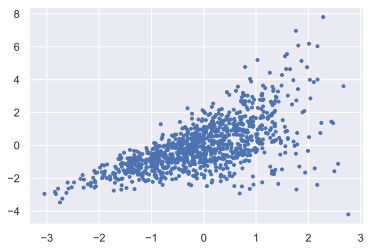

In [65]:
# A function to generate heteroskedastic data
def h_func(x):
    return x + np.exp(0.5*x)*np.random.randn(x.shape[0], 1)

# Generate heteroskedastic data
N = 1000
x = np.atleast_2d(np.random.randn(N)).T
y = h_func(x).ravel()

# Plot data we generated
plt.plot(x, y, '.');

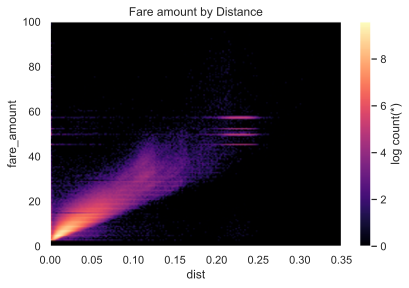

In [67]:
# Add distance to vaex df
train['dist'] = dist
vdf = vaex.from_pandas(train)

# Plot distance vs fare amount
lims = [[0, 0.35], [0, 100]]
cmap = matplotlib.cm.magma
cmap.set_bad('black', 1.)
vdf.plot('dist', 'fare_amount',
                limits=lims,
                f='log',
                colormap=cmap,
                shape=200,
                interpolation='spline16')
ax = plt.gca().grid(False)
plt.title('Fare amount by Distance');

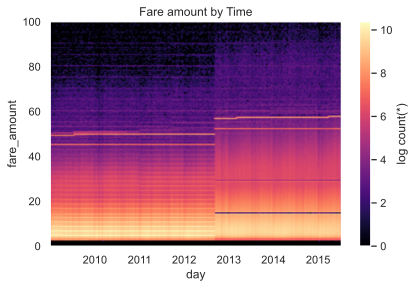

In [71]:
# Add distance to vaex df
train['day'] = dist
vdf = vaex.from_pandas(train)
vdf['day'] = vdf.day_of_year + 365*vdf.year

# Plot distance vs fare amount
lims = [[2009*365, 2015.52*365], [0, 100]]
cmap = matplotlib.cm.magma
cmap.set_bad('black', 1.)
vdf.plot('day', 'fare_amount',
                limits=lims,
                f='log',
                colormap=cmap,
                shape=200,
                interpolation='spline16')
ax = plt.gca().grid(False)
plt.xticks(365*np.arange(2010, 2016),
                  tuple(str(y) for y in np.arange(2010, 2016)))
plt.title('Fare amount by Time');

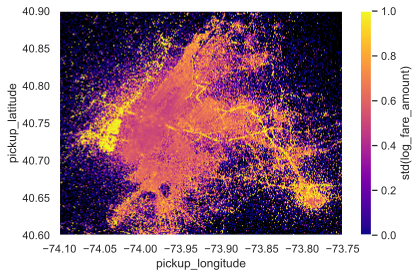

In [73]:
# Plot pickup locations as a heatmap
vdf['log_fare_amount'] = np.log(vdf.fare_amount)
lims = [[-74.1, -73.75], [40.6, 40.9]]

cmap = matplotlib.cm.plasma
cmap.set_bad('black', 1.)
vdf.plot('pickup_longitude', 'pickup_latitude',
                what='std(log_fare_amount)',
                limits=lims, colormap=cmap,
                vmin=0, vmax=1.,
                shape=300);

# Turn off grid
plt.gca().grid(False);

## Quantile Regression

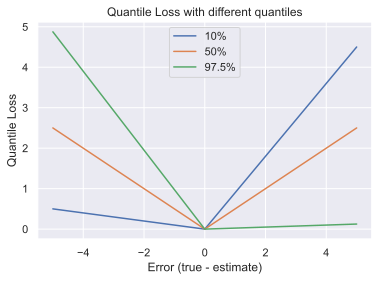

In [78]:
# Quantile loss function
def QuantileLoss(y_true, y_est, quantile):
    if type(y_true) is not np.ndarray:
        y_true = np.array(y_true)*np.ones_like(y_est)
    ix = (y_true < y_est)
    loss = np.zeros_like(y_est)
    loss[ix] = ((1-quantile)*np.abs(y_true[ix] - y_est[ix]))
    loss[~ix] = (quantile*np.abs(y_true[~ix] - y_est[~ix]))
    
    return loss

# Show loss @ different quantiles
xx = np.linspace(-5, 5, 101)
plt.plot(xx, QuantileLoss(0, xx, 0.1), label='10%')
plt.plot(xx, QuantileLoss(0, xx, 0.5), label='50%')
plt.plot(xx, QuantileLoss(0, xx, 0.975), label='97.5%')
plt.legend()
plt.title('Quantile Loss with different quantiles')
plt.xlabel('Error (true - estimate)')
plt.ylabel('Quantile Loss');

In [13]:
# Proportion of samples to hold out
VAL_SPLIT = 0.2

tr_ind = np.random.choice([False, True],
                          size=x_taxi.shape[0],
                          p=[VAL_SPLIT, 1.0-VAL_SPLIT])
x_train = x_taxi[tr_ind].values
y_train = y_taxi[tr_ind].values
x_val = x_taxi[~tr_ind].values
y_val = y_taxi[~tr_ind].values
N_train = x_train.shape[0]
N_val = x_val.shape[0]

# Make y 2d
y_train = np.expand_dims(y_train, 1)
y_val = np.expand_dims(y_val, 1)

In [15]:
# Gradient boosted tree regressors w/ different quantile losses
gbrL = CatBoostRegressor(loss_function='Quantile:alpha=0.025')
gbr = CatBoostRegressor(loss_function='Quantile:alpha=0.5')
gbrH = CatBoostRegressor(loss_function='Quantile:alpha=0.975')

# Fit to data
gbrL.fit(x_train, y_train)

0:	learn: 0.2015626	total: 156ms	remaining: 2m 36s
1:	learn: 0.2011816	total: 250ms	remaining: 2m 4s
2:	learn: 0.2004768	total: 335ms	remaining: 1m 51s
3:	learn: 0.1997985	total: 427ms	remaining: 1m 46s
4:	learn: 0.1992956	total: 515ms	remaining: 1m 42s
5:	learn: 0.1987139	total: 604ms	remaining: 1m 40s
6:	learn: 0.1982751	total: 693ms	remaining: 1m 38s
7:	learn: 0.1978248	total: 787ms	remaining: 1m 37s
8:	learn: 0.1972718	total: 876ms	remaining: 1m 36s
9:	learn: 0.1968224	total: 970ms	remaining: 1m 36s
10:	learn: 0.1963974	total: 1.06s	remaining: 1m 35s
11:	learn: 0.1960127	total: 1.15s	remaining: 1m 34s
12:	learn: 0.1956045	total: 1.25s	remaining: 1m 34s
13:	learn: 0.1951635	total: 1.35s	remaining: 1m 35s
14:	learn: 0.1946583	total: 1.45s	remaining: 1m 35s
15:	learn: 0.1942855	total: 1.55s	remaining: 1m 35s
16:	learn: 0.1939829	total: 1.64s	remaining: 1m 34s
17:	learn: 0.1936505	total: 1.72s	remaining: 1m 34s
18:	learn: 0.1932449	total: 1.82s	remaining: 1m 33s
19:	learn: 0.1928039	to

159:	learn: 0.1619748	total: 14.4s	remaining: 1m 15s
160:	learn: 0.1618887	total: 14.4s	remaining: 1m 15s
161:	learn: 0.1618019	total: 14.5s	remaining: 1m 15s
162:	learn: 0.1617010	total: 14.6s	remaining: 1m 15s
163:	learn: 0.1616420	total: 14.7s	remaining: 1m 14s
164:	learn: 0.1614805	total: 14.8s	remaining: 1m 14s
165:	learn: 0.1614115	total: 14.9s	remaining: 1m 14s
166:	learn: 0.1613412	total: 15s	remaining: 1m 14s
167:	learn: 0.1612036	total: 15.1s	remaining: 1m 14s
168:	learn: 0.1611425	total: 15.2s	remaining: 1m 14s
169:	learn: 0.1610292	total: 15.2s	remaining: 1m 14s
170:	learn: 0.1609167	total: 15.3s	remaining: 1m 14s
171:	learn: 0.1608223	total: 15.4s	remaining: 1m 14s
172:	learn: 0.1607670	total: 15.5s	remaining: 1m 14s
173:	learn: 0.1605647	total: 15.6s	remaining: 1m 13s
174:	learn: 0.1603777	total: 15.7s	remaining: 1m 13s
175:	learn: 0.1602332	total: 15.7s	remaining: 1m 13s
176:	learn: 0.1601732	total: 15.8s	remaining: 1m 13s
177:	learn: 0.1599793	total: 15.9s	remaining: 1m

318:	learn: 0.1455654	total: 27.9s	remaining: 59.5s
319:	learn: 0.1455178	total: 27.9s	remaining: 59.4s
320:	learn: 0.1454349	total: 28s	remaining: 59.3s
321:	learn: 0.1453390	total: 28.1s	remaining: 59.2s
322:	learn: 0.1451581	total: 28.2s	remaining: 59.1s
323:	learn: 0.1450706	total: 28.3s	remaining: 59s
324:	learn: 0.1449544	total: 28.4s	remaining: 58.9s
325:	learn: 0.1448593	total: 28.5s	remaining: 58.8s
326:	learn: 0.1448228	total: 28.5s	remaining: 58.7s
327:	learn: 0.1447623	total: 28.6s	remaining: 58.6s
328:	learn: 0.1447045	total: 28.7s	remaining: 58.5s
329:	learn: 0.1446620	total: 28.8s	remaining: 58.4s
330:	learn: 0.1446243	total: 28.9s	remaining: 58.3s
331:	learn: 0.1445553	total: 28.9s	remaining: 58.2s
332:	learn: 0.1444837	total: 29s	remaining: 58.2s
333:	learn: 0.1444154	total: 29.1s	remaining: 58.1s
334:	learn: 0.1443864	total: 29.2s	remaining: 58s
335:	learn: 0.1443372	total: 29.3s	remaining: 57.9s
336:	learn: 0.1442785	total: 29.4s	remaining: 57.8s
337:	learn: 0.144212

477:	learn: 0.1368449	total: 42s	remaining: 45.8s
478:	learn: 0.1368294	total: 42.1s	remaining: 45.7s
479:	learn: 0.1368158	total: 42.1s	remaining: 45.6s
480:	learn: 0.1367403	total: 42.2s	remaining: 45.6s
481:	learn: 0.1367079	total: 42.3s	remaining: 45.5s
482:	learn: 0.1366372	total: 42.4s	remaining: 45.4s
483:	learn: 0.1365889	total: 42.5s	remaining: 45.3s
484:	learn: 0.1365775	total: 42.6s	remaining: 45.2s
485:	learn: 0.1365561	total: 42.7s	remaining: 45.1s
486:	learn: 0.1365004	total: 42.7s	remaining: 45s
487:	learn: 0.1364298	total: 42.8s	remaining: 44.9s
488:	learn: 0.1363781	total: 42.9s	remaining: 44.8s
489:	learn: 0.1363263	total: 43s	remaining: 44.8s
490:	learn: 0.1363191	total: 43.1s	remaining: 44.7s
491:	learn: 0.1362944	total: 43.2s	remaining: 44.6s
492:	learn: 0.1362483	total: 43.2s	remaining: 44.5s
493:	learn: 0.1361872	total: 43.3s	remaining: 44.4s
494:	learn: 0.1361619	total: 43.4s	remaining: 44.3s
495:	learn: 0.1361534	total: 43.5s	remaining: 44.2s
496:	learn: 0.1360

638:	learn: 0.1312646	total: 55.9s	remaining: 31.6s
639:	learn: 0.1312498	total: 56s	remaining: 31.5s
640:	learn: 0.1312245	total: 56s	remaining: 31.4s
641:	learn: 0.1312017	total: 56.1s	remaining: 31.3s
642:	learn: 0.1311968	total: 56.2s	remaining: 31.2s
643:	learn: 0.1311534	total: 56.3s	remaining: 31.1s
644:	learn: 0.1311341	total: 56.4s	remaining: 31s
645:	learn: 0.1311135	total: 56.4s	remaining: 30.9s
646:	learn: 0.1310980	total: 56.5s	remaining: 30.8s
647:	learn: 0.1310880	total: 56.6s	remaining: 30.8s
648:	learn: 0.1310635	total: 56.7s	remaining: 30.7s
649:	learn: 0.1310299	total: 56.8s	remaining: 30.6s
650:	learn: 0.1309990	total: 56.9s	remaining: 30.5s
651:	learn: 0.1309855	total: 56.9s	remaining: 30.4s
652:	learn: 0.1309714	total: 57s	remaining: 30.3s
653:	learn: 0.1309518	total: 57.1s	remaining: 30.2s
654:	learn: 0.1309344	total: 57.2s	remaining: 30.1s
655:	learn: 0.1308798	total: 57.3s	remaining: 30s
656:	learn: 0.1308753	total: 57.4s	remaining: 30s
657:	learn: 0.1308475	to

798:	learn: 0.1277018	total: 1m 10s	remaining: 17.9s
799:	learn: 0.1276855	total: 1m 11s	remaining: 17.8s
800:	learn: 0.1276730	total: 1m 11s	remaining: 17.7s
801:	learn: 0.1276258	total: 1m 11s	remaining: 17.6s
802:	learn: 0.1276081	total: 1m 11s	remaining: 17.5s
803:	learn: 0.1275975	total: 1m 11s	remaining: 17.4s
804:	learn: 0.1275875	total: 1m 11s	remaining: 17.3s
805:	learn: 0.1275721	total: 1m 11s	remaining: 17.2s
806:	learn: 0.1275668	total: 1m 11s	remaining: 17.1s
807:	learn: 0.1275310	total: 1m 11s	remaining: 17.1s
808:	learn: 0.1275126	total: 1m 11s	remaining: 17s
809:	learn: 0.1274870	total: 1m 11s	remaining: 16.9s
810:	learn: 0.1274463	total: 1m 12s	remaining: 16.8s
811:	learn: 0.1274227	total: 1m 12s	remaining: 16.7s
812:	learn: 0.1274015	total: 1m 12s	remaining: 16.6s
813:	learn: 0.1273783	total: 1m 12s	remaining: 16.5s
814:	learn: 0.1273338	total: 1m 12s	remaining: 16.4s
815:	learn: 0.1273303	total: 1m 12s	remaining: 16.3s
816:	learn: 0.1273270	total: 1m 12s	remaining: 1

955:	learn: 0.1249223	total: 1m 24s	remaining: 3.9s
956:	learn: 0.1249122	total: 1m 24s	remaining: 3.81s
957:	learn: 0.1248926	total: 1m 24s	remaining: 3.72s
958:	learn: 0.1248784	total: 1m 25s	remaining: 3.63s
959:	learn: 0.1248637	total: 1m 25s	remaining: 3.55s
960:	learn: 0.1248550	total: 1m 25s	remaining: 3.46s
961:	learn: 0.1248366	total: 1m 25s	remaining: 3.37s
962:	learn: 0.1248223	total: 1m 25s	remaining: 3.28s
963:	learn: 0.1247847	total: 1m 25s	remaining: 3.19s
964:	learn: 0.1247777	total: 1m 25s	remaining: 3.1s
965:	learn: 0.1247551	total: 1m 25s	remaining: 3.01s
966:	learn: 0.1247317	total: 1m 25s	remaining: 2.92s
967:	learn: 0.1247188	total: 1m 25s	remaining: 2.84s
968:	learn: 0.1246939	total: 1m 25s	remaining: 2.75s
969:	learn: 0.1246820	total: 1m 25s	remaining: 2.66s
970:	learn: 0.1246730	total: 1m 26s	remaining: 2.57s
971:	learn: 0.1246560	total: 1m 26s	remaining: 2.48s
972:	learn: 0.1246425	total: 1m 26s	remaining: 2.39s
973:	learn: 0.1246382	total: 1m 26s	remaining: 2

In [ ]:
%%time
gbr.fit(x_train, y_train)

In [ ]:
%%time
gbrH.fit(x_train, y_train)

In [ ]:
# Predict over x range
xx = np.atleast_2d(np.linspace(-3, 3, N)).T
y_predL = gbrL.predict(xx)
y_pred = gbr.predict(xx)
y_predH = gbrH.predict(xx)

# Plot predictions over points
plt.figure()
plt.plot(x_val, y_val, '.',
                label='Validation data')
plt.fill_between(xx.ravel(), y_predL, y_predH,
                                alpha=0.3, facecolor=colors[1],
                                label='95% confidence interval')
plt.plot(xx, y_pred, 'k', label='Predicted median')
plt.legend()